In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
import warnings

import geopandas as gpd
from shapely.geometry import Point, LineString

from sklearn.pipeline import Pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from vincenty import vincenty

from helper_funcs import (wrangle, vincenty_distance, nearest_port, train_dbscan,
                          get_voyages, get_angle, prepare_data, get_pred_data,
                          vincenty_port, get_prior_port, fix_really_close_cluster,
                          fix_close_ports)
                          

warnings.filterwarnings("ignore")

In [ ]:
# defining the geopandas maps
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [ ]:
port_file = 'data/ports.csv'
tracking_file = 'data/tracking.csv'

In [ ]:
ports_df, tracking_df = wrangle(port_file=port_file, tracking_file=tracking_file)

print("the shape of the ports dataframe is:", ports_df.shape)
print("the shape of the tracking dataframe is:", tracking_df.shape)

ports_df.head()

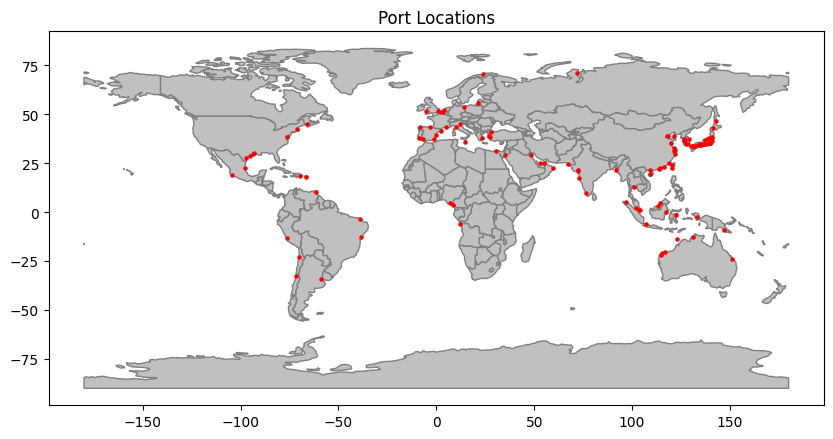

In [11]:
# creating a geopandas dataframe with the points
geometry = [Point(xy) for xy in zip(ports_df['long'], ports_df['lat'])]
port_gdf = gpd.GeoDataFrame(ports_df, geometry=geometry)

# using the world map defined above, creating a map
base = world.plot(figsize=(10, 10), color='#C0C0C0', edgecolor='#808080')

# using the geopandas dataframe to place port coordinates on the map
port_gdf.plot(ax=base, marker='o', color='red', markersize=5)

# title
plt.title('Port Locations')

plt.show()

In [4]:
tracking_df.head()

,vessel,datetime,lat,long,heading,speed,draft,vessel_1back,lat_rad,long_rad,lat_long,lat_long_1back,direction,time_delta,hour_delta,quad
0,1,2019-01-01 02:47:00,29.743,-93.8695,214.0,0.0,9.6,1.0,0.519113,-1.638332,"[29.743, -93.8695]","[29.743, -93.8695]",SW,0 days 00:54:00,0.9,quad2
1,1,2019-01-01 05:47:00,29.743,-93.8695,214.0,0.0,9.6,1.0,0.519113,-1.638332,"[29.743, -93.8695]","[29.743, -93.8695]",SW,0 days 03:00:00,3.0,quad2
2,1,2019-01-01 06:59:00,29.743,-93.8695,214.0,0.0,9.6,1.0,0.519113,-1.638332,"[29.743, -93.8695]","[29.743, -93.8695]",SW,0 days 01:12:00,1.2,quad2
3,1,2019-01-01 08:53:00,29.743,-93.8695,214.0,0.0,9.6,1.0,0.519113,-1.638332,"[29.743, -93.8695]","[29.743, -93.8695]",SW,0 days 01:54:00,1.9,quad2
4,1,2019-01-01 10:53:00,29.743,-93.8695,214.0,0.0,9.6,1.0,0.519113,-1.638332,"[29.743, -93.8695]","[29.743, -93.8695]",SW,0 days 02:00:00,2.0,quad2


In [80]:
def get_vessel_data(vessel, start_date, end_date):
    """
    Plot vessel locations between the start and end date. Uses
    a colormap to indicate distance from start/end date. 

    parameters:
        vessel (str): The name of the vessel.
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.
    """
    
    condition = (tracking_df['vessel'] == vessel) & \
                (tracking_df['datetime'].between(start_date, end_date))
    
    df_ = tracking_df[condition]
    df_['datetime'] = pd.to_numeric(df_['datetime'])
    df_['datetime'] = (df_['datetime'] - df_['datetime'].min()) / (df_['datetime'].max() - df_['datetime'].min())
    
    # creating points and the geopandas df
    geometry = [Point(xy) for xy in zip(df_['long'], df_['lat'])]
    vessel_gdf = gpd.GeoDataFrame(df_, geometry=geometry)    
    
    # creating the plot
    fig, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting the world map
    world.plot(ax=ax, color='#C0C0C0', edgecolor='#808080')

    cmap = cm.get_cmap('coolwarm')
    marker_color = cmap(vessel_gdf['datetime'])
    
    vessel_gdf.plot(ax=ax, marker='o', color=marker_color, markersize=15)
    
    # setting limits to get a nice zoom
    min_longitude = df_['long'].min() - 5
    max_longitude = df_['long'].max() + 5
    min_latitude = df_['lat'].min() - 5
    max_latitude = df_['lat'].max() + 5
    ax.set_xlim(min_longitude, max_longitude)
    ax.set_ylim(min_latitude, max_latitude)
    
    # cbet legend
    cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax, shrink=0.3)
    cbar.set_label('Normalized Date')
    
    # labels, title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Vessel {vessel} Route {start_date} to {end_date}')
    
    plt.show()

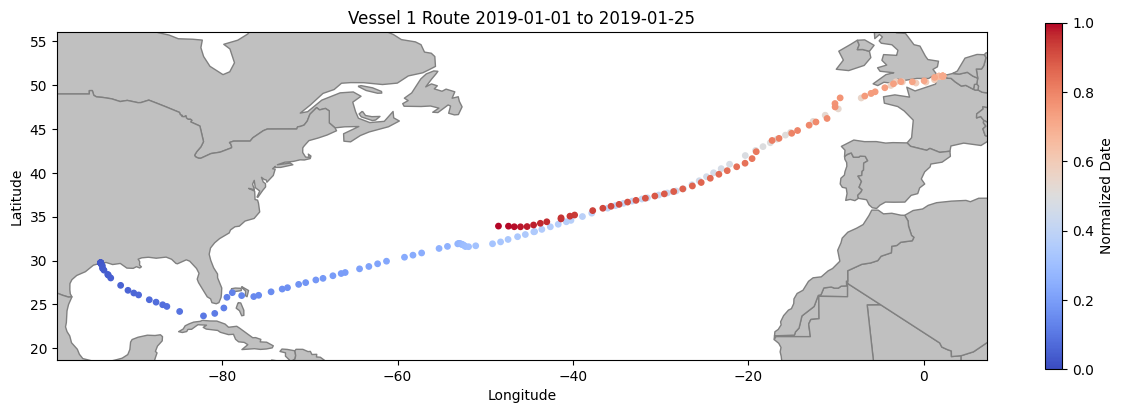

In [84]:
get_vessel_data(1, '2019-01-01', '2019-01-25')

In [5]:
# creating a dictionary of ports with their lat and longs 
ports = {port:(lat, long) for port, lat, long in zip(ports_df['port'], ports_df['lat'], ports_df['long'])}

# a dictionary assigning ports to integers and vice versa
idx_ports = {idx:port for idx, port in zip(ports_df.index, ports_df.port)}
rev_idx_ports = {v:k for k, v in idx_ports.items()}

In [82]:
# Getting the Vincenty distances for each pair of ports in the ports.csv file
# and identifying  those that are within 100km of each other

close_ones = []

for x in ports_df['lat_long']:
    distances = []
    for y in ports_df['lat_long']:
        vdist = vincenty(x, y)
        distances.append(vdist)
    close_ones.append(distances)

# this is a list of tuples with ports and their distances to the 4 nearest ports
disters = [[(ports_df['port'].iloc[n], z) for n, z in zip(np.argsort(p)[:5], sorted(p)[:5])] for p in close_ones]

close_ones = {}
for n in disters:
    port = n[0][0]
    dees = {d:v for d, v in n[1:] if v < 100}
    close_ones[port] = dees

close_ones = {k:v for k,v in close_ones.items() if len(v) >= 1}

# A list of ports that are very close to other ports 
really_close = [30, 109, 42, 51, 65, 71, 108, 139, 63, 152, 102]

In [7]:
# training a nearest neighbor model to  find the closest port when the 
# conditions indicating an extended stop have occurred. the metric is haversine
# in order to compute the 'great circle' distance. so i don't forget, the model
# returns the *index* of the port, not the port's identifying label

ports_train = ports_df[['lat_rad', 'long_rad']]

kneigh_port_model = NearestNeighbors(n_neighbors=3, algorithm='ball_tree', metric='haversine')
kneigh_port_model.fit(ports_train)

# selecting an example coordinate and printing the (port, distance)
dist, n = kneigh_port_model.kneighbors(np.array([0.677565, 0.469731]).reshape(1,-1))

for d, i in zip(dist[0], n[0]):
    print("port, distance for the coordinate:", (idx_ports[i], d * 6370))

port, distance for the coordinate: (82, 3.3093102570558104)
port, distance for the coordinate: (113, 46.44757564974505)
port, distance for the coordinate: (44, 255.13837716039743)


In [8]:
# clustering the ports using db scan and then creating a dictionary of labels 
ports_df['labels'] = train_dbscan(df=ports_df, eps=0.1, min_samples=4)

db_labels = {port:cluster for port, cluster in zip(ports_df['port'], ports_df['labels'])}

In [9]:
# calculating the distance between each row using the vincenty function above.
# note it only calcs within each vessel group (see function). the elapsed time
# and the total distance travelled implies a speed and that speed creates a 
# simple filter. 

tracking_df['vin_diff'] = tracking_df.apply(vincenty_distance, axis=1)
tracking_df['vin_per_hour'] = tracking_df['vin_diff'] / tracking_df['hour_delta']
tracking_df = tracking_df.query('vin_per_hour <= 50')
tracking_df = tracking_df.sort_values(by=['vessel', 'datetime'])

# time deltas to be used later to filter voyages and a new lat/long calc 

tracking_df['time_delta'] = tracking_df.groupby('vessel')['datetime'].transform(lambda x: x - x.shift(-1))
tracking_df['hour_delta'] = [abs(n.total_seconds()/3600) for n in tracking_df['time_delta']]
tracking_df['lat_long_1back'] = tracking_df.groupby('vessel')['lat_long'].transform(lambda x: x.shift())

In [10]:
# calculating draft forwards and backwards - note all of these values
# should be recalculated using shift(-1) - shift(1) but i was new!

tracking_df['draft_raw'] = tracking_df.groupby('vessel')['draft'].transform(lambda x: x.diff())
tracking_df['draft_delta_back'] = tracking_df.groupby('vessel')['draft'].transform(lambda x: abs(x.diff()).ge(0.69)).astype(int)
tracking_df['draft_delta_ahead'] = tracking_df.groupby('vessel')['draft'].transform(lambda x: abs(x.diff(-1)).ge(0.69)).astype(int)
tracking_df['draft_change'] = ((tracking_df['draft_delta_back'] + tracking_df['draft_delta_ahead']) >= 1).astype(int)

# calculating heading change. same comment.
tracking_df['heading_change'] = tracking_df.groupby('vessel')['heading'].transform(lambda x: abs(x.diff()))
tracking_df['heading_change'] = [360 - x if x > 180 else x for x in tracking_df['heading_change']]
tracking_df['heading_seq'] = tracking_df.groupby('vessel')['heading'].transform(lambda x: abs(x.diff()).gt(3).cumsum()+1)

In [11]:
# to briefly explain whats happening here, the knearest neighbors model is being used
# to assign the most likely port given the coordinates of the row in the tracking file.
# this takes a few minutes. 
# afterwards i define *sequences* of rows using the 'not equal' 

tracking_df['pred_port'] = (
    tracking_df
    .apply(nearest_port, axis=1, kneigh_model=kneigh_port_model, idx_ports=idx_ports, radius=0.015)
)

tracking_df['pred_port_backup'] = tracking_df['pred_port']

# defining sequences of rows with the same port predicted for each vessel. the transformation
# step takes the difference (.diff) between conseuctive rows and asks (ne(0))
# whether that difference is equal to zero. these sequences define a vessel as 'in port'
tracking_df['port_sequence'] = tracking_df.groupby('vessel')['pred_port'].transform(lambda x: x.diff().ne(0).cumsum())

In [12]:
# defining sequences of rows with a port predicted - finds movement from
# one port to another and so identifies sequences w/ambiguous intended port

tracking_df['consec_port_sequence'] = (
    tracking_df
    .groupby('vessel')['pred_port_backup']
    .transform(lambda x: x.gt(0).astype(int).diff().ne(0).cumsum())
)

In [13]:
# calculating the distance from the predicted port using the more precise 
# vincenty distance. a mask is applied to speed it up.

tracking_df['port_coords'] = [list(ports[k]) if k in ports else -99 for k in tracking_df['pred_port']]

mask = tracking_df['pred_port'] > 0
temp_df = tracking_df[mask]

tracking_df['pred_port_dist'] = 0
tracking_df.loc[mask, 'pred_port_dist'] = temp_df.apply(vincenty_port, axis=1)

In [14]:
# calculating features that will help determine the intention of 
# vessels

# minimum distance from port while near port
tracking_df['port_sequence_min_dist'] = (
    tracking_df
    .groupby(['vessel', 'port_sequence'])['pred_port_dist']
    .transform(lambda x: x.min())
)

# total length of time near port
tracking_df['port_sequence_time'] = (
    tracking_df
    .groupby(['vessel', 'port_sequence'])['hour_delta']
    .transform(lambda x: abs(x).sum())
)

# length of time with a static heading while near port
tracking_df['heading_sequence_time'] = (
    tracking_df
    .groupby(['vessel', 'heading_seq'])['hour_delta']
    .transform(lambda x: abs(x).sum())
)

# min distance from nearest port when near two ports
# consecutively
tracking_df['consec_port_min_dist'] = (
    tracking_df
    .groupby(['vessel', 'consec_port_sequence'])['pred_port_dist']
    .transform(lambda x: round(x.min(), 2))
)

In [15]:
# getting the last port with a function and then flattening the lists it
# returns for each vessel and appending them to the dataframe

last_ports = tracking_df.groupby("vessel").apply(get_prior_port)
last_ports_col = []

for lps in last_ports:
    for lp in lps:
        last_ports_col.append(lp)

tracking_df['prior_port'] = last_ports_col
tracking_df['dist_last_port'] = (
    [vincenty(l, ports[p]) if p>0 else 0 for l, p in zip(tracking_df['lat_long'], tracking_df['prior_port'])]
)

In [16]:
# calculating the rolling unique predicted port values using two lambdas
# and a filter
tracking_df['rolling_unique_vals'] = (
    tracking_df
    .groupby('vessel')['pred_port_backup']
    .transform(lambda x: x.rolling(8, center=True).apply(lambda x: x[x>0].nunique()))
)

# getting the minimum distance from a port over the window using two lambdas
# and a filter

tracking_df['window_min_dist'] = (
    tracking_df
    .groupby('vessel')['pred_port_dist']
    .transform(lambda x: x.rolling(8, center=True).apply(lambda x: x[x>0].min()))
)

In [21]:
# processing the dataframes with conditions. it is setup this way to allow for
# fast iteration. 

# looking at this several years later, this is data preprocessing on 
# vessel-specific dataframes. this seems quite hacky, but it did improve 
# port identification by allowing me to spot anomalies.

processed_dfs = {}

for df in tracking_df.vessel.unique():
    df_ = tracking_df.query(f'vessel == {df}').set_index('datetime')
    df_['pred_port'] = np.where(df_['draft_change'] < 1, 0, df_['pred_port'])
  
    condition = ((df_['pred_port'].isin(really_close)) & (df_['pred_port_dist'] >13))
    df_['pred_port'] = np.where(condition, 0, df_['pred_port'])

    df_['pred_port'] = df_.apply(fix_really_close_cluster, axis=1)

    df_['pred_port'] = np.where(df_['port_sequence_time'] < 16, 0, df_['pred_port'])

    df_['fixed_ports'] = fix_close_ports(df_)
    df_['pred_port'] = [x if x == y else 0 for x, y in zip(df_['pred_port_backup'], df_['fixed_ports'])]

    condition2 = (df_['pred_port'].isin([115, 54]) & (df_['pred_port_dist'] >16))
    df_['pred_port'] = np.where(condition2, 0, df_['pred_port'])

    df_['pred_port'] = df_.apply(fix_really_close_cluster, axis=1)

    last_ports = df_.groupby('vessel').apply(get_prior_port)
    last_ports_col = []

    for lps in last_ports:
        for lp in lps:
              last_ports_col.append(lp)

    condition = ((df_['heading_sequence_time'] < 6) & (df_['pred_port'] >0) & (df_['draft_change'] <1))
    df_['pred_port'] = np.where(condition, 0, df_['pred_port'])

    condition2 = ((df_['pred_port_dist'] - df_['consec_port_min_dist']) > 10)
    df_['pred_port'] = np.where(condition2, 0, df_['pred_port'])

    condition3 = (df_['pred_port_dist'] > 80)
    df_['pred_port'] = np.where(condition3, 0, df_['pred_port'])

    df_['prior_port'] = last_ports_col
    df_['dist_last_port'] = [vincenty(l, ports[p]) if p>0 else 0 for l, p in zip(df_['lat_long'], df_['prior_port'])]

    processed_dfs[df] = df_

alldf = pd.concat(processed_dfs)

In [22]:
# here i am creating a new dataframe of voyages this
# this dataframe is important as it is one of the submissions dataframes!!
voyages_df = pd.concat([get_voyages(processed_dfs[key]) for key in processed_dfs.keys()])

voyages_df['begin_date'] = voyages_df['begin_date'].dt.date
voyages_df['end_date'] = voyages_df['end_date'].dt.date
voyages_df['len_voyage'] = voyages_df['end_date'] - voyages_df['begin_date']
voyages_df['begin_coords'] = [ports[key] for key in voyages_df['begin_port_id']]
voyages_df['end_coords'] = [ports[key] for key in voyages_df['end_port_id']]
voyages_df['voyage_dist'] = [vincenty(x, y) for x, y in zip(voyages_df['begin_coords'], voyages_df['end_coords'])]

print(voyages_df.shape)

(3331, 9)


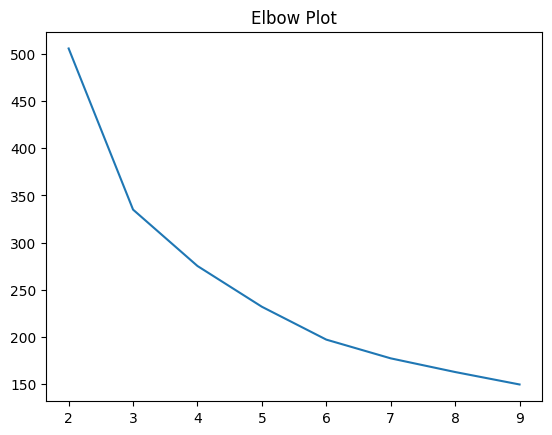

In [23]:
# creating a simple clustering model of vessels using KMeans
# the thinking was that vessels will be active in similar
# regions

vessel_hours = tracking_df.groupby(['vessel', 'quad'])['hour_delta'].sum().abs().reset_index()
vessel_df = vessel_hours.pivot(index='vessel', columns='quad', values='hour_delta').fillna(0)
vessel_df = vessel_df.div(vessel_df.sum(axis=1), axis=0)
vessel_df = vessel_df.merge(voyages_df.groupby('vessel')['voyage_dist'].mean(), left_index=True, right_index=True)

# scaling the values
scaler = StandardScaler()
scaled_vessel_df = scaler.fit_transform(vessel_df)

# using a loop to determine the number of clusters to use
kmeans_inertias = []

for n in range(2, 10):
    kmeans_vessels = KMeans(n_clusters=n)
    kmeans_vessels.fit(scaled_vessel_df)
    kmeans_inertias.append(kmeans_vessels.inertia_)

plt.plot(range(2,10), kmeans_inertias)
plt.title("Elbow Plot")
plt.show()

In [24]:
# the kmeans model that's used in the models - 3 works better than 6 
# when incorporated into the model

kmeans_vessels = KMeans(n_clusters = 3)
kmeans_vessels.fit(scaled_vessel_df)

kmeans_vessels.labels_

vessel_df['labels'] = kmeans_vessels.labels_

# creating a dictionary with the labels
kmeans_labels = {v:label for v, label in zip(vessel_df.index, vessel_df['labels'])}

In [27]:
def build_model(target='port_1ahead', min_samples=1, n_back = 3, min_examples=2):
    """
    A function to build models for each n-ahead port. 
    
    It should be noted that I am training on the  entire on the entire X and y here to maximize the information available
    to the model prior to my submission. Originally I validated the method and tuned the parameters using a 
    validation set. 
    
    When I originally did this xgboost did not require target variables to be ordered from 0 to n-1 (total classes).
    I therefore had to include a LabelEncoder in this version.    
    
    """

    model_df = pd.concat([prepare_data(processed_dfs[key], n_back, kmeans_labels) for key in processed_dfs.keys()])
    
    for i in range(0, n_back):
        model_df[f'cluster_{i+1}back'] = [db_labels[n] for n in model_df[i]]

    examples = model_df[target].value_counts()
    singles = examples[examples < min_examples].index

    model_df = model_df[~model_df[target].isin(singles)]

    model_df['samples'] = model_df.groupby('vessel')['vessel'].transform(lambda x: x.count())
    filtered_df = model_df.query('samples > @min_samples').copy()

    vessels_excluded = set(model_df['vessel'].unique()).difference(set(filtered_df['vessel'].unique()))
    print("excluded vessels:", vessels_excluded)
    
    # the features are the clusters from t
    features = [n for n in range(n_back)] + ['cluster_1back', 'cluster_2back', 'cluster_3back', 'kmeans_label'] 
    target = target
    
    model = XGBClassifier()
    target_encoder = LabelEncoder()

    X = filtered_df[features].copy()
    y = filtered_df[target].copy()
    y = target_encoder.fit_transform(y)

    param_grid = {
      'learning_rate': [0.01, 0.05],
      'max_depth' : [3, 4]
  }
    grid_search = GridSearchCV(model, param_grid,cv=3)
    grid_result = grid_search.fit(X, y)

    print('The training excluded vessels:', vessels_excluded)
    print('The best model params were:', grid_result.best_params_)
    print('The best accuracy achieved was:', grid_result.best_score_)

    return grid_result, target_encoder

In [28]:
# because i had to use the label encoder to reproduce the results
# i rewrote the model function to return the label encoder for
# the target

model_1ahead, target_encoder_1 = build_model(target='port_1ahead', min_samples=2, n_back=3, min_examples=5)
model_2ahead, target_encoder_2 = build_model(target='port_2ahead', min_samples=2, n_back=3, min_examples=5)
model_3ahead, target_encoder_3 = build_model(target='port_3ahead', min_samples=2, n_back=3, min_examples=5)

excluded vessels: {64, 107, 75, 85}
The training excluded vessels: {64, 107, 75, 85}
The best model params were: {'learning_rate': 0.05, 'max_depth': 4}
The best accuracy achieved was: 0.4227879324927027
excluded vessels: {107, 75, 85}
The training excluded vessels: {107, 75, 85}
The best model params were: {'learning_rate': 0.01, 'max_depth': 4}
The best accuracy achieved was: 0.4115674700770618
excluded vessels: {107, 75, 85}
The training excluded vessels: {107, 75, 85}
The best model params were: {'learning_rate': 0.01, 'max_depth': 4}
The best accuracy achieved was: 0.36492171649331134


In [29]:
# creating a dictionary with the most recent ports visited for each vessel
# using the get_pred_data function here.

window_data = {key:get_pred_data(processed_dfs[key], n_input=3) for key in processed_dfs.keys()}

In [35]:
# creating a dataframe with the features used in the models

sub = pd.DataFrame.from_dict(window_data, orient='index')

sub['cluster_1back'] = [db_labels[n] for n in sub[0]]
sub['cluster_2back'] = [db_labels[n] for n in sub[1]]
sub['cluster_3back'] = [db_labels[n] for n in sub[2]]
sub['kmeans_label'] = [kmeans_labels[n] for n in sub.index]

In [36]:
# predicting the next port. also including the second most likely port in case
# the model predicts duplicates. 
# *** NOTE THE TARGET ENCODER IS NOT IN THE ORIGINAL, BUT I INCLUDED IT HERE
# TO REPRODUCE THE RESULTS ***

port_1 = model_1ahead.predict(sub)
port_1 = target_encoder_1.inverse_transform(port_1)
port_2 = model_2ahead.predict(sub)
port_2 = target_encoder_2.inverse_transform(port_2)
port_2_alt = [model_2ahead.best_estimator_.classes_[np.argsort(n)[-2]] for n in model_2ahead.predict_proba(sub)]
port_2_alt = target_encoder_2.inverse_transform(port_2_alt)
port_3 = model_3ahead.predict(sub)
port_3 = target_encoder_3.inverse_transform(port_3)
port_3_alt = [model_3ahead.best_estimator_.classes_[np.argsort(n)[-2]] for n in model_3ahead.predict_proba(sub)]
port_3_alt = target_encoder_3.inverse_transform(port_3_alt)

sub['port_1ahead'] = port_1
sub['port_2ahead'] = port_2
sub['port_2ahead_2nd'] = port_2_alt
sub['port_3ahead'] = port_3
sub['port_3ahead_2nd'] = port_3_alt

# using conditional assignment to replace port predictions with the second most
# likely

sub.loc[sub['port_1ahead'] == sub['port_2ahead'], 'port_2ahead'] = sub['port_2ahead_2nd']
sub.loc[sub['port_2ahead'] == sub['port_3ahead'], 'port_3ahead'] = sub['port_3ahead_2nd']

In [37]:
# changing the shape of the dataframe so it conforms to what's required

# resetting the index and renaming the column
sub = sub.reset_index()
sub.rename(columns={'index':'vessel'}, inplace=True)

# limiting columns to those required and renaming
sub = sub[['vessel', 2, 'port_1ahead', 'port_2ahead', 'port_3ahead']]
sub.rename(columns={2:'final_port'}, inplace=True)

# using melt to narrow the DataFrame and put the voyages into the same column
sub = pd.melt(sub, id_vars='vessel').sort_values(by=['vessel', 'variable'])
sub['end_port_id'] = sub.groupby('vessel')['value'].transform(lambda x: x.shift(-1))
sub = sub.dropna()

# adding a voyage count, more renaming
sub['voyage'] = sub.groupby('vessel').cumcount()+1
sub.rename(columns={'value' : 'begin_port_id'}, inplace=True)
sub.drop(columns=['variable'], inplace=True)
sub['end_port_id'] = sub['end_port_id'].astype(int)
sub = sub.reset_index(drop=True)

In [ ]:
# the voyages (first part of the contest was to reconstruct accurate voyage histories)
voyages_df.to_csv('voyages.csv', index=False)

# the predicted voyages (second part of the contest was to predict the next 3 ports)
# naturally, your ability to predict the next 3 ports depended on your success
# reconstructing the previous visited ports
sub.to_csv('predict.csv', index=False)